In [1]:
from matador.query import DBQuery
from matador.hull import QueryConvexHull
from matador.utils.chem_utils import get_molar_mass
from matador.utils.chem_utils import FARADAY_CONSTANT_Cpermol, Cperg_to_mAhperg
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def lithiation_capacity(A, doc, stable_products, elemental_products, debug=False):
    from matador.utils.chem_utils import get_generic_grav_capacity
    num_atoms_per_fu = 0
    num_li = 0
    gravimetric_capacity = 0
    stoichiometry = doc['stoichiometry']
    reaction = []
    accounted_for_mass = 0
    unaccounted_for_mass = 0
    final_volume_per_b = 0
    for elem in stoichiometry:
        num_atoms_per_fu += elem[1]
    for elem in stoichiometry:
        if A+elem[0] in stable_products:
            product = stable_products[A+elem[0]]
            for _elem in product['stoichiometry']:
                if _elem[0] == elem[0]:
                    num_product = elem[1] / _elem[1]
                elif _elem[0] == A:
                    num_A_per_fu = _elem[1]
            gravimetric_capacity += product['gravimetric_capacity'] * num_product
            num_li += num_A_per_fu * num_product
            final_volume_per_b += product['cell_volume'] / product['num_fu'] * num_product
            reaction.append((round(num_product, 3), product['stoichiometry']))
            accounted_for_mass += get_molar_mass(elem[0]) * num_product
        else:
            product = elemental_products[elem[0]]
            num_product = elem[1]
            reaction.append((round(num_product, 3), product['stoichiometry']))
            unaccounted_for_mass += get_molar_mass(elem[0]) * num_product
            final_volume_per_b += product['cell_volume'] / product['num_fu'] * num_product
    products = dict()
    for _product in reaction:
        for _elem in _product[1]:
            if _elem[0] not in products:
                products[_elem[0]] = 0.0
            products[_elem[0]] += _product[0] * _elem[1]
    concs = [products[A]]
    elem_list = [A]
    for __elem in products:
        if __elem != A:
            concs.append(products[__elem])
            elem_list.append(__elem)
    if debug:
        print(concs, elem_list)
    gravimetric_capacity = get_generic_grav_capacity(concs, elem_list)
    initial_volume = doc['cell_volume'] / doc['num_fu']
    volumetric_capacity = num_li / (doc['cell_volume'] / doc['num_fu']) * FARADAY_CONSTANT_Cpermol * Cperg_to_mAhperg
    mass_factor = accounted_for_mass/(unaccounted_for_mass + accounted_for_mass)
    volume_expansion = 100*(final_volume_per_b - initial_volume) / initial_volume
    volume_expansion_per_A = (final_volume_per_b - initial_volume) / num_li
    if debug:
        print(num_li)
        print(stoich2form(stoichiometry), '->', reaction)
        print(initial_volume, '->', final_volume_per_b)
        print(mass_factor)
        print(str(volume_expansion) + '%', volume_expansion_per_A)
        print(60*'-')
    return gravimetric_capacity, volumetric_capacity, volume_expansion, volume_expansion_per_A, reaction

In [3]:
def stoich2form(stoich):
    form = ''
    for elem in stoich:
        if elem[1] == 1:
            form += elem[0]
        else:
            form += elem[0] + str(elem[1])
    return form

In [4]:
A = ['Li']
X = ['Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Al', 'Si', 'Ga', 'Ge', 'As', 'Sn', 'Sb']
Y = ['P', 'S', 'Se', 'Si', 'Al', 'Sn', 'Sb', 'Zn', 'Ga', 'Ge', 'As']
XY = set()

In [118]:
%%capture
stable_phases = []
try:
    for x in X:
        for y in Y:
            if x == y:
                continue
            query = DBQuery(db='oqmd_1.1', subcmd='hull', details=False, summary=True, composition=[x+y])
            hull = QueryConvexHull(query, hull_cutoff=1e-2, no_plot=True)
            for phase in hull.hull_cursor:
                if len(phase['stoichiometry']) == 2:
                    stable_phases.append(phase)
                    XY.add(x+y)
except:
    print(x, y)

In [119]:
%%capture
from itertools import chain
stable_products = dict()
for elem in chain(X, Y):
    for a in A:
        query = DBQuery(db='oqmd_1.1', subcmd='hull', details=False, summary=True, composition=[a+elem])
        hull = QueryConvexHull(query, hull_cutoff=0, no_plot=True)
        if len(hull.hull_cursor) > 2:
            # get most lithiated phase on hull
            max_grav = 0
            max_ind = 0
            for ind, doc in enumerate(hull.hull_cursor):
                grav = hull.hull_cursor[ind]['gravimetric_capacity']
                if grav != np.NaN and max_grav < grav:
                    max_ind = ind
                    max_grav = grav
            stable_products[a+elem]= hull.hull_cursor[max_ind]

In [120]:
%%capture
elemental_products = dict()
for elem in X:
    query = DBQuery(db='oqmd_1.1', subcmd='query', details=False, summary=True, composition=[elem])
    if len(query.cursor) > 0:
        elemental_products[elem] = query.cursor[0]

In [141]:
for ind, phase in enumerate(stable_phases):
    stable_phases[ind]['gravimetric_capacity'], stable_phases[ind]['volumetric_capacity'], \
    stable_phases[ind]['volume_expansion'], stable_phases[ind]['volume_expansion_per_A'], stable_phases[ind]['products'] = \
        lithiation_capacity('Li', phase, stable_products, elemental_products, debug=False)

_stable_phases = pd.DataFrame(stable_phases)
_stable_products = pd.DataFrame([phase for phase in stable_products.values()])
_elemental_products = pd.DataFrame([phase for phase in elemental_products.values()])

_stable_phases["formula"] = list(map(stoich2form, _stable_phases["stoichiometry"]))
_stable_phases.drop_duplicates(subset='formula', inplace = True)

_stable_products["formula"] = list(map(stoich2form, _stable_products["stoichiometry"]))
_elemental_products["formula"] = list(map(stoich2form, _elemental_products["stoichiometry"]))

_stable_phases["cell_volume_per_atom"] = list(map(lambda x, y: x/y, _stable_phases["cell_volume"], _stable_phases['num_atoms']))
_stable_products["cell_volume_per_atom"] = list(map(lambda x, y: x/y, _stable_products["cell_volume"], _stable_products['num_atoms']))
_elemental_products["cell_volume_per_atom"] = list(map(lambda x, y: x/y, _elemental_products["cell_volume"], _elemental_products['num_atoms']))

_stable_phases["cell_volume_per_fu"] = list(map(lambda x, y: x/y, _stable_phases["cell_volume"], _stable_phases['num_fu']))
_stable_phases["_id"] = list(map(lambda x: str(x), _stable_phases["_id"]))
_stable_phases["reaction"] = list(map(lambda x: str(x[0][0] if x[0][0] != 1 else '')+' '+stoich2form(x[0][1]) +' + '+str(x[1][0] if x[1][0] != 1 else '')+ ' ' + stoich2form(x[1][1]), _stable_phases['products']))

_stable_phases["Y_type"] = list(map(lambda x: 'P' if 'P' in x else 'Si' if 'Si' in x else 'Se' if 'Se' in x \
                                         else 'Sc' if 'Sc' in x else 'Sb' if 'Sb' in x else 'S' if 'S' in x else 'other', _stable_phases['formula']))
_stable_phases["Y_type_ind"] = list(map(lambda x: 1.0 if 'P' in x else 2.0 if 'Si' in x else 3.0 if 'Se' in x \
                                         else 4.0 if 'Sc' in x else 5.0 if 'Sb' in x else 6.0 if 'S' in x else 7.0, _stable_phases['formula']))
_stable_phases["X_type"] = list(map(lambda x: 'Al' if 'Al' in x else 'Zn' if 'Zn' in x else 'Ge' if 'Ge' in x \
                                         else 'Ni' if 'Ni' in x else 'Fe' if 'Fe' in x else 'Cu' if 'Cu' in x else 'other', _stable_phases['formula']))
_stable_phases["X_type_ind"] = list(map(lambda x: 1.0 if 'Al' in x else 2.0 if 'Zn' in x else 3.0 if 'Ge' in x \
                                         else 4.0 if 'Ni' in x else 5.0 if 'Fe' in x else 6.0 if 'Cu' in x else 7.0, _stable_phases['formula']))
_stable_phases["class_P_alpha"] = list(map(lambda x: 0.9 if 'P' in x else 0.2, _stable_phases['formula']))
_stable_phases["initial_targets_alpha"] = list(map(lambda x: 0.9 if 'P' in x and ('Al' in x or 'Zn' in x or 'Sn' in x or 'Ti' in x or 'Cu' in x) else 0.2, _stable_phases['formula']))

In [136]:
pd.set_option('display.max_rows', 500)
_stable_phases[['formula', 'volumetric_capacity','gravimetric_capacity', 'volume_expansion', 'volume_expansion_per_A', 'reaction', 'Y_type']] \
               .sort_values(by='volume_expansion_per_A', ascending=False)

,formula,volumetric_capacity,gravimetric_capacity,volume_expansion,volume_expansion_per_A,reaction,Y_type
4,ScSe,1366.966979,432.609908,95.225570,18.671925,Sc + Li2Se,Se
35,SeTi2,1097.551497,306.863719,76.420234,18.662808,Li2Se + 2 Ti,Se
37,SeTi,1533.311418,422.680111,98.434289,17.207175,Li2Se + Ti,Se
221,AlCo,1744.611219,467.969044,111.564297,17.140367,0.5 Al2Li3 + Co,other
185,AlFe,1704.761571,485.417341,108.251075,17.020100,0.5 Al2Li3 + Fe,other
30,STi2,1221.332853,419.465336,76.014004,16.682192,Li2S + 2 Ti,S
79,SV3,1072.136968,289.942103,66.355552,16.589013,Li2S + 3 V,S
176,Fe2Se3,1986.986890,461.375768,122.560371,16.532883,2 Fe + 3.0 Li2Se,Se
182,AlFe3,857.822149,206.694188,52.546128,16.418633,0.5 Al2Li3 + 3 Fe,other
175,Fe3Se4,1887.396483,443.607969,114.688895,16.287400,3 Fe + 4.0 Li2Se,Se


In [142]:
from bokeh.plotting import figure
import matplotlib.pyplot as plt
from bokeh.layouts import column, row, widgetbox
from bokeh.models import HoverTool, ColumnDataSource, Slider, CustomJS, Select, ColorBar, LinearColorMapper, Span, Range1d
from bokeh.io import output_notebook, show
from bokeh.themes import Theme
output_notebook()

Theme('theme.yaml')
text_props = {
    "font": '\"Fira Sans\", sans-serif',
}

data = dict()
data['gravimetric_capacity'] = list(_stable_phases['gravimetric_capacity'])
data['volumetric_capacity'] = list(_stable_phases['volumetric_capacity'])
data['formula'] = list(_stable_phases['formula'])
data['reaction'] = list(_stable_phases['reaction'])
data['volume_expansion_per_A'] = list(_stable_phases['volume_expansion_per_A'])
data['volume_expansion'] = list(_stable_phases['volume_expansion'])
data['Y_type'] = list(_stable_phases['Y_type'])
data['X_type'] = list(_stable_phases['Y_type'])
data['Y_type_ind'] = list(_stable_phases['Y_type_ind'])
data['X_type_ind'] = list(_stable_phases['X_type_ind'])
data['class_P_alpha'] = list(_stable_phases['class_P_alpha'])
data['initial_targets_alpha'] = list(_stable_phases['initial_targets_alpha'])
data['original_bokeh_alpha'] = len(_stable_phases)*[0.9]
data['bokeh_alpha'] = len(_stable_phases)*[0.9]
def get_cmap_from_data(field, data):
    colormap = plt.cm.get_cmap('viridis')
    cmap_limits = [np.min(data[field]), np.max(data[field])]
    cmap_input = np.interp(data[field], cmap_limits, [0, 1])
    colours = colormap(cmap_input, 1, True)
    bokeh_colours = ["#%02x%02x%02x" % (r, g, b) for r, g, b in colours[:, 0:3]]
    return bokeh_colours
data['volume_expansion_colours'] = get_cmap_from_data('volume_expansion', data)
data['volume_expansion_per_A_colours'] = get_cmap_from_data('volume_expansion_per_A', data)
data['class_X_colours'] = get_cmap_from_data('X_type_ind', data)
data['class_Y_colours'] = get_cmap_from_data('Y_type_ind', data)
data['bokeh_colours'] = data['volume_expansion_colours']
data = ColumnDataSource(data)

Loading BokehJS ...

In [144]:
hover = HoverTool(tooltips="""
                    <div>
                        <span style="font-size: 14px; font-family: \"Fira Sans\", Arial, sans-serif;">
                        @formula -> @reaction <br>
                        @volume_expansion % <br>
                        @volume_expansion_per_A A^3 <br>
                        @gravimetric_capacity
                        </span>
                    </div>
                   """)

tools = ['pan', 'wheel_zoom', 'box_zoom', 'reset']
tools.append(hover)
fig = figure(tools=tools, toolbar_location='below', toolbar_sticky=False)
fig.plot_width = 800
fig.plot_height = 600
fig.outline_line_color = None
fig.scatter('gravimetric_capacity', 'volumetric_capacity',
            fill_color='bokeh_colours', line_color=None, size=12, alpha='bokeh_alpha', source=data)
fig.set(x_range=Range1d(0, 2600), y_range=Range1d(0, 7100))
fig.xaxis.axis_label = "gravimetric capacity (mAh/g)"
fig.xaxis.axis_label_text_font = '\"Fira Sans\", sans-serif'
fig.yaxis.axis_label = "volumetric capacity (mAh/cm^3)"
fig.yaxis.axis_label_text_font = '\"Fira Sans\", sans-serif'
fig.yaxis.axis_label_text_font = '\"Fira Sans\", sans-serif'
fig.xaxis.axis_label_text_font_size = '14pt'
fig.yaxis.axis_label_text_font_size = '14pt'
fig.yaxis.axis_label_text_font_style = 'normal'
fig.xaxis.axis_label_text_font_style = 'normal'
fig.yaxis.major_label_text_font = '\"Fira Sans\", sans-serif'
fig.yaxis.major_label_text_font_size = '12pt'
fig.xaxis.major_label_text_font = '\"Fira Sans\", sans-serif'
fig.xaxis.major_label_text_font_size = '12pt'

color_mapper = LinearColorMapper(palette="Viridis256", low=0, high=400)
color_bar = ColorBar(color_mapper=color_mapper, title='%', title_text_font_size='12pt', major_label_text_font_size='12pt',
                     major_label_text_font='\"Fira Sans\", sans-serif', title_text_font='\"Fira Sans\", sans-serif',
                     label_standoff=12, border_line_color=None, location=(0,0))
callback = CustomJS(args=dict(source=data, cmapper=color_mapper),
                    code="""
                             var data = source.data;
                             var menu_option = menu.value;
                             // var low = cmapper.low;
                             // var high = cmapper.high;
                             if(menu_option == 'Volume expansion per A (A^3)'){
                                 data['bokeh_colours'] = data['volume_expansion_per_A_colours'];
                                 data['bokeh_alpha'] = data['original_bokeh_alpha'];
                             } else if(menu_option == 'Volume expansion %'){
                                 data['bokeh_colours'] = data['volume_expansion_colours'];
                                 data['bokeh_alpha'] = data['original_bokeh_alpha'];
                             } else if(menu_option == 'Class by Y'){
                                 data['bokeh_colours'] = data['class_Y_colours'];
                                 data['bokeh_alpha'] = data['original_bokeh_alpha'];
                             } else if(menu_option == 'Class by X'){
                                 data['bokeh_colours'] = data['class_X_colours'];
                                 data['bokeh_alpha'] = data['original_bokeh_alpha'];
                             } else if(menu_option == 'Highlight phosphides'){
                                 data['bokeh_alpha'] = data['class_P_alpha'];
                             } else if(menu_option == 'Highlight initial targets'){
                                 data['bokeh_alpha'] = data['initial_targets_alpha'];
                             }
                             source.trigger('change');
                         """)
colour_menu = Select(title="Colour by:", value="Volume expansion %",
                     options=["Volume expansion %", "Volume expansion per A (A^3)",
                              "Class by X", "Class by Y", "Highlight phosphides",
                              "Highlight initial targets"], callback=callback)
callback.args['menu'] = colour_menu#, color_mapper

# graphite
hline = Span(location=400, dimension='width', line_color='red', line_width=2)
vline = Span(location=372, dimension='height', line_color='red', line_width=2)


fig.add_layout(color_bar, 'right')
fig.renderers.extend([vline, hline])
layout = column(
    widgetbox(colour_menu),
    fig,
)

show(layout, notebook_handle=True)

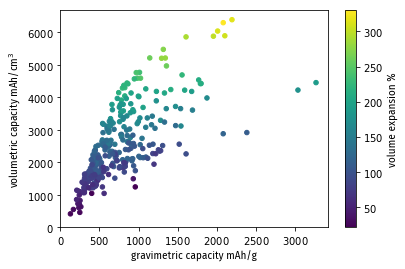

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
_stable_phases.plot.scatter('gravimetric_capacity', 'volumetric_capacity', ax=ax, c='volume_expansion', colormap='viridis', xlim=1, ylim=0)
ax.set_xlabel('gravimetric capacity mAh/g')
ax.set_ylabel('volumetric capacity mAh/cm$^3$')
cmap_ax = fig.get_axes()[1]
cmap_ax.set_ylabel('volume expansion %')